In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
        
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
plotly=4.6.0 already installed
chart-studio=1.1.0 already installed
plotly-orca=1.3.1 already installed
Running command `conda install --yes unicodedata2`... ok
Solving environment: ...working... done

# All requested packages already installed.


Importando librerías ...
Las librerías has sido importadas con éxito


In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

import re
import unicodedata

%matplotlib inline

# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

In [3]:
def scatter(y_test, y_pred, y):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Medido')
    ax.set_ylabel('Predicho')
    plt.show()

In [4]:
# LECTURA DEL ARCHIVO DE DATOS
data_clean = pd.read_csv("CleanCSV/Clean08_OultiersxZona.csv")
#data_clean =  pd.read_csv('CleanCSV/Clean08_OultiersxZona_Ale_02.csv')

In [5]:
# SÓLO PARA USO EN COMPARACIONES
data_clean_ORIGINAL = data_clean.copy(deep=True) 

In [6]:
data_clean.head(3)

,Unnamed: 0,Unnamed: 0.1,País,Provincia,Área,Localidad,Zona,Lugar,operation,property_type,...,gimnasio,subte,baulera,piscina_house,piscina_depart,desc_banios,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,0,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,PH,...,0.0,0.0,0.0,0,0,1.0,1,0,0,0
1,1,1,Argentina,Buenos Aires,Zona Sur,La Plata,La Plata,La Plata,sell,apartment,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0
2,2,2,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,apartment,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0


In [7]:
display(data_clean.shape)
data_clean.columns

(118570, 44)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store'], dtype='object')

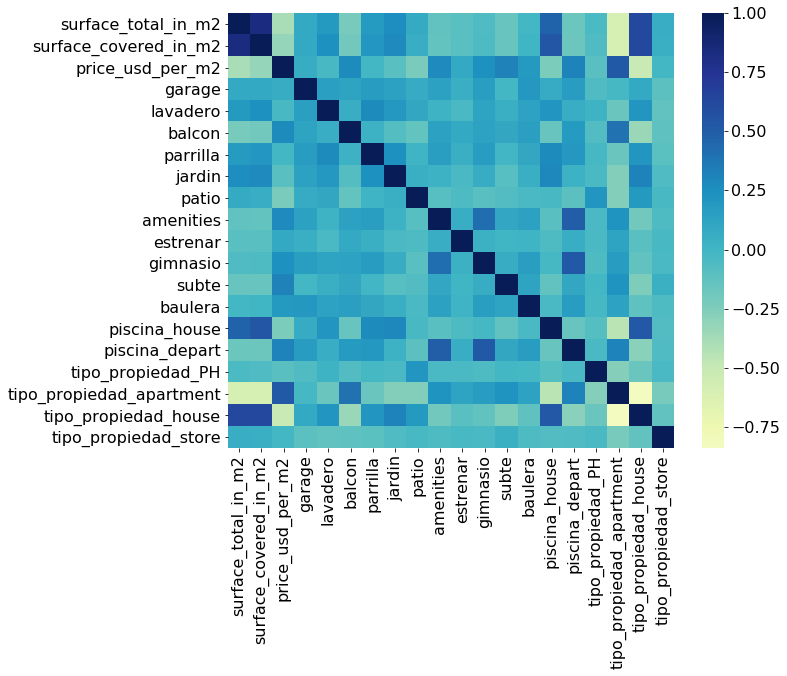

In [8]:
dfCompleto = data_clean.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
                                                                          'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
                                                                          'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
                                                                          'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
                                                                          'tipo_propiedad_apartment', 'tipo_propiedad_house',
                                                                          'tipo_propiedad_store', "Lugar"]]
sns.heatmap(dfCompleto.corr(), center=0, cmap="YlGnBu", annot=False);

### 0) Primer aproximación al Modelo con lo datos disponibles sólo en Capital

#### Hacemos esto para comparar los R2 que obtendremos más adelante utilizando otros features que harán que el dataset disponible varíe

In [9]:
Xo_yo = data_clean.loc[(data_clean["Área"] == "Capital Federal")].loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
                                                                          'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
                                                                          'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
                                                                          'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
                                                                          'tipo_propiedad_apartment', 'tipo_propiedad_house',
                                                                          'tipo_propiedad_store', "Lugar"]]
Xo_yo.isnull().sum()

surface_total_in_m2         1336
surface_covered_in_m2       2646
price_usd_per_m2            6071
garage                         0
lavadero                       0
balcon                         0
parrilla                       0
jardin                         0
patio                          0
amenities                      0
estrenar                       0
gimnasio                       0
subte                          0
baulera                        0
piscina_house                  0
piscina_depart                 0
tipo_propiedad_PH              0
tipo_propiedad_apartment       0
tipo_propiedad_house           0
tipo_propiedad_store           0
Lugar                          0
dtype: int64

In [10]:
# Eliminamos con nulos
Xo_yo.dropna(how="any", axis=0, inplace= True)
Xo_yo.shape

(23971, 21)

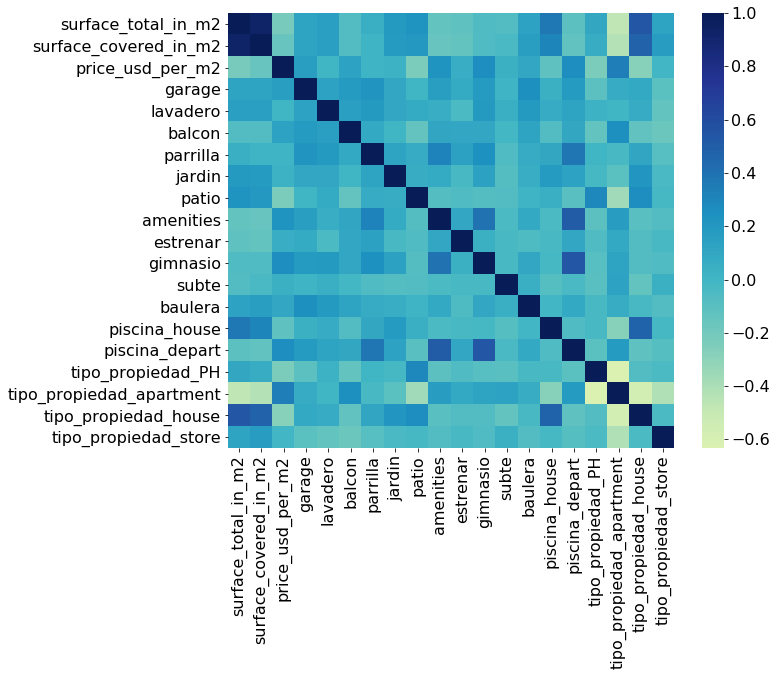

In [11]:
sns.heatmap(Xo_yo.corr(), center=0, cmap="YlGnBu", annot=False);

In [12]:
Xo = Xo_yo[['surface_total_in_m2', 'surface_covered_in_m2',  
            'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
            'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
            'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
            'tipo_propiedad_apartment', 'tipo_propiedad_house',
            'tipo_propiedad_store', "Lugar"]]
Xo.shape

(23971, 20)

#### 0-a) Armamos las Dummies de "Lugar" (Para el caso de Capital federal, son los barrios/sub-barrios):

In [13]:
dummies_lugar = pd.get_dummies(Xo['Lugar'], prefix="dumm", drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lugar.shape

(23971, 61)

In [14]:
Xo = pd.concat([Xo, dummies_lugar],axis=1)
Xo.drop(['Lugar'], axis=1, inplace=True)

In [15]:
Xo.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'dumm_Agronomía', 'dumm_Almagro', 'dumm_Balvanera', 'dumm_Barracas', 'dumm_Barrio Norte', 'dumm_Belgrano', 'dumm_Boca', 'dumm_Boedo', 'dumm_Caballito', 'dumm_Capital Federal', 'dumm_Catalinas', 'dumm_Centro / Microcentro', 'dumm_Chacarita', 'dumm_Coghlan', 'dumm_Colegiales', 'dumm_Congreso', 'dumm_Constitución', 'dumm_Flores', 'dumm_Floresta', 'dumm_Las Cañitas', 'dumm_Liniers', 'dumm_Mataderos', 'dumm_Monserrat', 'dumm_Monte Castro', 'dumm_Nuñez', 'dumm_Once', 'dumm_Palermo', 'dumm_Palermo Chico', 'dumm_Palermo Hollywood', 'dumm_Palermo Soho', 'dumm_Palermo Viejo', 'dumm_Parque Avellaneda', 'dumm_Parque Centenario', 'dumm_Parque Chacabuco', 'dumm_Parque Chas', 'dumm_Parque Patricios'

In [16]:
yo = Xo_yo[['price_usd_per_m2']]
yo.shape

(23971, 1)

In [17]:
print("Shape X:", Xo.shape)
print("Type X:", type(Xo))
print("Shape y:", yo.shape)
print("Type y:", type(yo))

Shape X: (23971, 80)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (23971, 1)
Type y: <class 'pandas.core.frame.DataFrame'>


#### 0-b) Usando STATS MODEL - Armamos "Xo_const":

In [18]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [19]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
Xo_const = sm.add_constant(Xo)
Xo_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,parrilla,jardin,patio,amenities,...,dumm_Villa Lugano,dumm_Villa Luro,dumm_Villa Ortuzar,dumm_Villa Pueyrredón,dumm_Villa Real,dumm_Villa Riachuelo,dumm_Villa Santa Rita,dumm_Villa Soldati,dumm_Villa Urquiza,dumm_Villa del Parque
0,1.0,55.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 0-c) Usando STATS MODEL - con "Xo_const":

In [20]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(Xo_const, yo)

In [21]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 243554.34509353773
EMC train: 251235.03225903795
R2:  0.5782294302902441
R2: train: 0.5782294302902441
R2: TEST: 0.5643788584147832


In [22]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     306.7
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:29:29   Log-Likelihood:            -1.3700e+05
No. Observations:               17978   AIC:                         2.742e+05
Df Residuals:                   17897   BIC:                         2.748e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

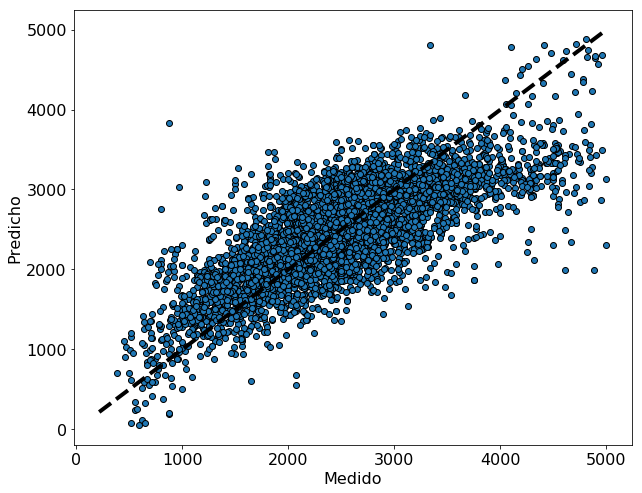

In [23]:
scatter(y_test, predictions2, yo)

##### Se observa que para los Datos de Capital Federal, incluyendo Dummies por Barrio obtenermos, R2 Train/Test de 0,58 / 0,55.


### AHORA VAMOS A VOLVER A TODO EL DATASET DISPONIBLE PARA TODA LA ARGENTINA:

<hr id="Ubicaciones">

### 1) Imputamos valores adicionales en la columna "ROOMS"

In [24]:
print(data_clean.rooms.isnull().sum())

64741


In [25]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\sambientes", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambientes", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

64741
53585


In [26]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\samb", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" amb", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

53585
50429


In [27]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("1\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambiente", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
50429


In [28]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("un\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("un ambiente", "1").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
49892


In [29]:
data_clean = data_clean.drop(columns=["description"])

### 2) BINARIZACIÓN DE LAT-LOT (ARMADO DE PARCELAS)

In [30]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

50412


50412

In [31]:
# Eliminamos filas sin LAT o LOT
data_clean.dropna(subset=['lat', 'lon'], how="any", axis=0, inplace= True)

In [32]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

0


0

In [33]:
data_clean.shape

(68158, 43)

In [34]:
# Vemos cómo nos queda distribuídas geográficamente las muestras luego del Drop anterior
data_clean.Área.value_counts()[0:40]

Capital Federal        23204
Zona Norte             11197
Costa Atlántica         8029
Zona Sur                5849
Zona Oeste              5515
Santa Fe                5232
Córdoba                 5044
Interior                1513
Neuquén                  470
Río Negro                432
Misiones                 363
Mendoza                  333
Entre Ríos               258
Salta                    207
Tucumán                  128
San Luis                 126
La Pampa                  64
Chubut                    52
Chaco                     40
San Juan                  23
Jujuy                     22
Tierra Del Fuego          22
Santa Cruz                17
Corrientes                10
La Rioja                   4
Catamarca                  3
Santiago Del Estero        1
Name: Área, dtype: int64

In [35]:
# Con 4000 BINS en LAT se obtienen una resolución de 0.015 grados por BIN (unas 14 cuadras)
lat_bins= pd.cut(data_clean.lat, 4000, right=False)
display(lat_bins)
lat_categories = pd.cut(data_clean.lat, 4000, right=False, labels=False) # labels=False implica que me devuelve el bin al que pertenece
lat_categories

0         [-34.668, -34.653)
1         [-34.905, -34.891)
2         [-34.653, -34.638)
3         [-34.653, -34.638)
4         [-38.007, -37.993)
                 ...        
118503    [-34.609, -34.594)
118508    [-34.594, -34.579)
118510    [-34.564, -34.549)
118559    [-34.564, -34.549)
118567    [-34.579, -34.564)
Name: lat, Length: 68158, dtype: category
Categories (4000, interval[float64]): [[-54.824, -54.809) < [-54.809, -54.794) < [-54.794, -54.779) < [-54.779, -54.765) ... [4.486, 4.501) < [4.501, 4.516) < [4.516, 4.531) < [4.531, 4.605)]

0         1358
1         1342
2         1359
3         1359
4         1133
          ... 
118503    1362
118508    1363
118510    1365
118559    1365
118567    1364
Name: lat, Length: 68158, dtype: int64

In [36]:
lat_categories = lat_categories.astype("str", copy=True)
type(lat_categories[0])

str

In [37]:
# Con 2000 BINS en LON se obtienen una resolución de 0.011 grados por BIN (unas 8 cuadras)
lon_bins= pd.cut(data_clean.lon, 2000, right=False)
display(lon_bins)
lon_categories = pd.cut(data_clean.lon, 2000, right=False, labels=False) # labels=False impluca que me devuelve el bin al que pertenece
lon_categories.value_counts()

0         [-58.517, -58.506)
1         [-57.969, -57.958)
2         [-58.528, -58.517)
3         [-58.517, -58.506)
4         [-57.552, -57.541)
                 ...        
118503    [-58.408, -58.397)
118508    [-58.408, -58.397)
118510    [-58.452, -58.441)
118559    [-58.452, -58.441)
118567    [-58.485, -58.474)
Name: lon, Length: 68158, dtype: category
Categories (2000, interval[float64]): [[-75.679, -75.668) < [-75.668, -75.657) < [-75.657, -75.646) < [-75.646, -75.635) ... [-53.777, -53.766) < [-53.766, -53.755) < [-53.755, -53.744) < [-53.744, -53.711)]

1652    3379
1574    2742
1571    2621
1570    2138
1568    2123
        ... 
726        1
917        1
1492       1
1428       1
0          1
Name: lon, Length: 753, dtype: int64

In [38]:
lon_categories = lon_categories.astype("str", copy=True)
type(lon_categories[0])

str

In [39]:
lat_lon = lat_categories + "/" + lon_categories
lat_lon.value_counts()

1133/1652    2024
1363/1574     769
1132/1652     618
1364/1571     617
1365/1569     605
             ... 
1556/1024       1
1838/1731       1
1337/1616       1
1885/945        1
1480/624        1
Length: 3988, dtype: int64

In [40]:
lat_lon.shape

(68158,)

In [41]:
data_clean = pd.concat([data_clean, lat_lon], axis=1)

In [42]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 0], dtype='object')

In [43]:
# Renombramos la columna que recién creamos (por defecto la llamó 0)
data_clean.rename(columns={0: "lat_lon"}, inplace=True)

### 3) Eliminamos algunas columnas que ya no utilizaremos

In [44]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

In [45]:
data_clean.drop(['Unnamed: 0', 'Unnamed: 0.1', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 
                 'floor', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 
                 'desc_banios'], axis=1, inplace=True)

In [46]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

### 4) Generamos DUMMIES para los pares de LAT-LON que generamos antes

In [47]:
dummies_lat_lon = pd.get_dummies(data_clean['lat_lon'], drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lat_lon.shape

(68158, 3987)

In [48]:
data_clean = pd.concat([data_clean, dummies_lat_lon],axis=1)

In [49]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       ...
       '989/400', '989/401', '990/397', '990/400', '990/404', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=4016)

### 4) "dataf" es una dataframe intermedio donde verificamos que ya no tengamos nulos en las columnas de interés

In [50]:
data_clean.isnull().sum()[0:20]

País                         0
Provincia                    0
Área                         0
Localidad                    0
Zona                         0
Lugar                        0
price_aprox_usd          10998
surface_total_in_m2      11165
surface_covered_in_m2    12841
price_usd_per_m2         19058
rooms                    16987
garage                       0
lavadero                     0
balcon                       0
parrilla                     0
jardin                       0
patio                        0
amenities                    0
estrenar                     0
gimnasio                     0
dtype: int64

In [51]:
dataf = data_clean.dropna(how="any", axis=0)

In [52]:
dataf.isnull().sum().sum()

0

In [53]:
dataf.shape

(35739, 4016)

In [54]:
# Vemos nuevamente cómo nos quedan los datos disponibles distribuídos geográficamente
dataf.Área.value_counts()[0:40]

Capital Federal        16317
Zona Norte              5832
Costa Atlántica         4740
Zona Sur                2398
Zona Oeste              2280
Santa Fe                1657
Córdoba                 1531
Interior                 476
Neuquén                  150
Río Negro                128
Misiones                  78
Mendoza                   58
Salta                     19
Tierra Del Fuego          13
Entre Ríos                12
Tucumán                   11
Chaco                     10
Chubut                     8
San Luis                   8
Santa Cruz                 6
La Rioja                   2
Jujuy                      2
Corrientes                 2
Santiago Del Estero        1
Name: Área, dtype: int64

In [55]:
dataf.columns[0:30]

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon', '0/669'], dtype='object')

### 5) Armamos X e y

In [56]:
X = dataf.drop(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_usd_per_m2', 'lat_lon', 'price_aprox_usd'], axis=1)

In [57]:
X.shape

(35739, 4007)

In [58]:
y = dataf['price_usd_per_m2']

In [59]:
y.shape

(35739,)

In [60]:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (35739, 4007)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (35739,)
Type y: <class 'pandas.core.series.Series'>


<hr id="Ubicaciones">

### 6) Pimera aproximación con STATS MODEL - OLS

In [61]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [62]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
X_const = sm.add_constant(X)
X_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,rooms,garage,lavadero,balcon,parrilla,jardin,patio,...,989/400,989/401,990/397,990/400,990/404,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 6-a) Usando "X_const":

In [63]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_const, y)

In [64]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 177164.6235271541
EMC train: 203636.92492283162
R2:  0.7468312197757861
R2: train: 0.746831219775786
R2: TEST: 0.7073294309926224


In [65]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     36.80
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:31:23   Log-Likelihood:            -1.9999e+05
No. Observations:               26804   AIC:                         4.040e+05
Df Residuals:                   24814   BIC:                         4.203e+05
Df Model:                        1989                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

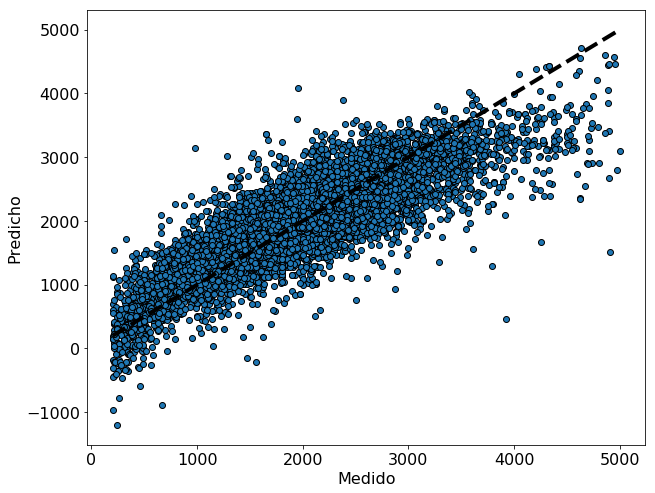

In [66]:
scatter(y_test, predictions2, y)

##### El uso de las parcelas es muy importante para el modelo.
##### Se mostró más arriba que intentamos utilizar dummies de la columna "Lugar" en lugar de las parcelas y no obteníamos R2 mejores a 0,56 / 0,57

### Primer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [67]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values

In [68]:
not_feature_cols

array(['rooms', 'parrilla', 'jardin', ..., '989/399', '989/400',
       '990/404'], dtype=object)

#### Armamos "X2_const":

In [69]:
X2_const = X_const.drop(not_feature_cols, axis=1)

In [70]:
X2_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,988/397,989/396,989/401,990/397,990/400,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Segunda aproximación con STATS MODEL - OLS

#### Usando "X2_const"

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X2_const, y)

In [72]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 199509.66468712347
EMC train: 206565.27094762595
R2:  0.7148804950469996
R2: train: 0.7148804950469996
R2: TEST: 0.7031589716124297


In [73]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:31:38   Log-Likelihood:            -2.0159e+05
No. Observations:               26804   AIC:                         4.040e+05
Df Residuals:                   26396   BIC:                         4.073e+05
Df Model:                         407                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1518.4584      7.988    190.091      0.000    1502.801    1534.115
surface_total_in_m2      -3.3699      0.053    -63.386      0.000      -3.474      -3.266
surface_covered_in_m2     1.6204      0.077     21.154      0.000       1.470       1.771
garage                  126.4824      6.156     20.547      0.000     114.417     138.548
lavadero                -26.8530      6.112     -4.393      0.000     -38.833     -14.873
balcon                   69.8309      6.118     11.413      0.000      57.839      81.823
patio                  -247.5800      7.643    -32.395      0.000    -262.560    -232.600
amenities                90.7412     10.839      8.372      0.000      69.496     111.986
estrenar                109.4433      9.654     11.336      0.000      90.521     128.366
gimnasio                206.0628     12.499     16.486      0.000     181.564     230.562
baulera                  48.7084      9.067      5.372      0.000      30.936      66.481
piscina_house           114.1842     14.690      7.773      0.000      85.391     142.978
piscina_depart          188.0955      9.922     18.957      0.000     168.648     207.543
1064/740               -571.4949    201.406     -2.838      0.005    -966.261    -176.729
1066/737              -1.048e-12    1.1e-10     -0.010      0.992   -2.16e-10    2.14e-10
1069/693                922.4017     61.245     15.061      0.000     802.358    1042.446
1070/683              -7.561e-11   1.74e-10     -0.436      0.663   -4.16e-10    2.64e-10
1080/1235             -3.242e-12   3.37e-10     -0.010      0.992   -6.63e-10    6.57e-10
1107/1404              -409.1665    170.260     -2.403      0.016    -742.885     -75.448
1115/1624              -296.3836    450.202     -0.658      0.510   -1178.803     586.036
1115/1626              -194.0484    103.570     -1.874      0.061    -397.050       8.954
1126/1645               689.8127    136.639      5.048      0.000     421.994     957.632
1127/1652              -362.7104    116.368     -3.117      0.002    -590.797    -134.624
1131/1652               244.7935     79.809      3.067      0.002      88.363     401.224
1131/1653               891.1644     70.513     12.638      0.000     752.955    1029.374
1131/1654              1459.1876    450.330      3.240      0.001     576.516    2341.859
1132/1650               225.1172     54.898      4.101      0.000     117.515     332.720
1132/1651               410.5786     51.571      7.961      0.000     309.498     511.660
1132/1652               396.8272     27.321     14.525      0.000     343.277     450.377
1132/1653               451.0068     33.933     13.291      0.000     384.496     517.517
1132/1654               857.0061     76.362     11.223      0.000     707.332    1006.680
1133/1651              

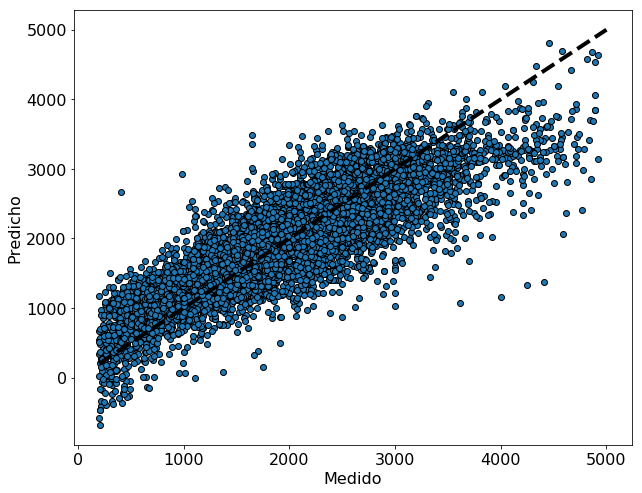

In [74]:
scatter(y_test, predictions2, y)

In [75]:
X2_const.columns

Index(['const', 'surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio',
       ...
       '988/397', '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1419)

#### Segunda eliminación de features con STATS MODEL - OLS
##### Este paso lo realizamos porque próximamente generaremos nuevas features y si la mantenemos todas ahora, luego las PC no logran alojar en memoria el procesamiento necesario


In [76]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['1066/737', '1070/683', '1080/1235', '1107/1404', '1115/1624',
       '1115/1626', '1134/1649', '1136/1631', '1178/1699', '1181/1702',
       '1191/1712', '1192/1712', '1194/1717', '1199/1690', '1222/1731',
       '1291/1087', '1297/1609', '1338/1617', '1340/1595', '1340/1619',
       '1341/1576', '1343/1608', '1344/1566', '1348/1594', '1349/1581',
       '1354/1540', '1356/1574', '1358/1559', '1358/1565', '1363/1535',
       '1363/1559', '1364/1509', '1364/1559', '1367/1558', '1367/1564',
       '1368/1544', '1369/1522', '1369/1563', '1372/1519', '1373/1541',
       '1373/1550', '1382/1540', '1386/1559', '1391/1448', '1391/1523',
       '1391/1560', '1393/1514', '1394/1119', '1394/1120', '1394/1480',
       '1394/1511', '1395/1518', '1402/1072', '1402/591', '1410/1379',
       '1410/1472', '1410/1473', '1412/1381', '1416/1472', '1420/1249',
       '1423/1458', '1423/1459', '1423/1460', '1423/928', '1424/1458',
       '1424/1460', '1424/930', '1426/1452', '1431/605', '1440/1357'

#### Armamos "X3_const":

In [77]:
X3_const = X2_const.drop(not_feature_cols, axis=1)

In [78]:
X3_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,988/397,989/396,989/401,990/397,990/400,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Tercera aproximación con STATS MODEL - OLS

#### Usando "X3_const"

In [79]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 200580.0325555883
EMC train: 215122.95120493768
R2:  0.7126065126507177
R2: train: 0.7126065126507177
R2: TEST: 0.6932783335395196


#### Observamos que el modelo mantiene el R2 de Test y Train luego de haber filtrado parámetros con Pvlues mayores al 1%

In [80]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     224.3
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:31:49   Log-Likelihood:            -2.0166e+05
No. Observations:               26804   AIC:                         4.039e+05
Df Residuals:                   26510   BIC:                         4.063e+05
Df Model:                         293                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1514.7852      7.839    193.245      0.000    1499.421    1530.149
surface_total_in_m2      -3.3255      0.052    -64.530      0.000      -3.426      -3.224
surface_covered_in_m2     1.5929      0.075     21.278      0.000       1.446       1.740
garage                  122.8647      6.127     20.052      0.000     110.855     134.874
lavadero                -22.8450      6.091     -3.750      0.000     -34.785     -10.905
balcon                   69.0339      6.092     11.332      0.000      57.094      80.974
patio                  -246.6115      7.589    -32.496      0.000    -261.486    -231.737
amenities                89.3721     10.823      8.257      0.000      68.158     110.587
estrenar                105.2096      9.642     10.911      0.000      86.310     124.109
gimnasio                197.7179     12.381     15.969      0.000     173.450     221.986
baulera                  42.7211      9.056      4.717      0.000      24.971      60.472
piscina_house           107.0942     14.403      7.435      0.000      78.863     135.326
piscina_depart          196.6495      9.837     19.990      0.000     177.367     215.931
1064/740               -583.5482    260.086     -2.244      0.025   -1093.331     -73.765
1069/693                910.7400     69.938     13.022      0.000     773.658    1047.822
1126/1645               620.3051    136.551      4.543      0.000     352.657     887.953
1127/1652              -324.2683    125.019     -2.594      0.009    -569.311     -79.225
1131/1652               254.9517     85.349      2.987      0.003      87.664     422.240
1131/1653               844.4988     70.540     11.972      0.000     706.236     982.761
1131/1654              3.654e-10   9.25e-11      3.953      0.000    1.84e-10    5.47e-10
1132/1650               186.0085     54.909      3.388      0.001      78.384     293.633
1132/1651               421.6647     51.603      8.171      0.000     320.521     522.809
1132/1652               422.6858     26.918     15.703      0.000     369.925     475.446
1132/1653               442.5401     34.200     12.940      0.000     375.507     509.573
1132/1654               927.8905     75.320     12.319      0.000     780.258    1075.523
1133/1651               347.3758     36.748      9.453      0.000     275.347     419.405
1133/1652               427.8858     16.181     26.444      0.000     396.171     459.601
1134/1647              -336.5790    170.319     -1.976      0.048    -670.413      -2.745
1134/1652               447.2250     36.856     12.135      0.000     374.986     519.464
1140/1631             -9.009e-10    7.5e-10     -1.201      0.230   -2.37e-09    5.69e-10
1167/1253             -8.517e-10   3.64e-10     -2.342      0.019   -1.56e-09   -1.39e-10
1178/1511             -

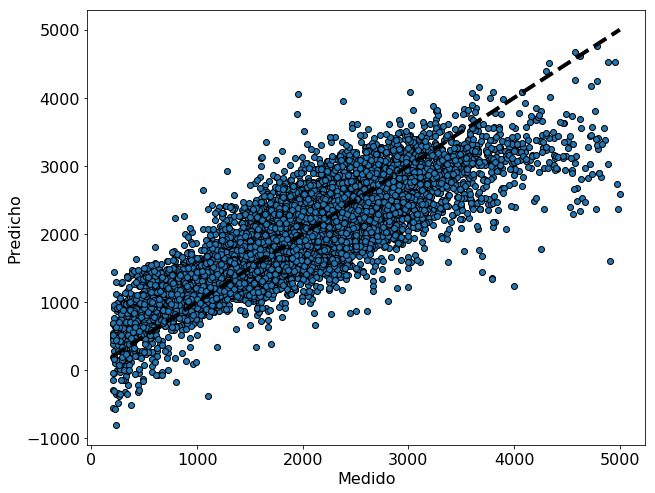

In [81]:
scatter(y_test, predictions2, y)

### 7) Probando diferentes Modelos

#### Armamo "X3" (sólo se requiere eliminar la columna "const")

In [82]:
X3 = X3_const.drop(["const"], axis=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X3, y)

#### 7-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [84]:
# X_train, X_test, y_train, y_test
# SIEMPRE NORMALIZAMOS CUANDO HACEMOS REGULARIZACIÓN (RIGDE, LASSO, ETC..) PORQUE SINO COMO LOS BETAS DE CADA
# FEATURE ESTÁN EN ESCALAS DIFERENTE, PENALIZARÍA MAS A FEATURES EN RANGOS MUY GRANDES,
# ES DECIR, PENALIZARÍA DIFERENTE A CADA FEATURE
# ADEMÁS, AYUDA AL TIEMPO DE PROCESAMIENTO
# OJO QUE LOS BETA QUE OBTENEMOS ESTARÁN TAMBIÉN EN OTRA ESCALA, TAMBIÉN ESTARÁN NORMALIZADOS

rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

# Ajustamos nuevamente, esta vez con regularizacion (RIDGE)
ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)
# SUPUESTAMENTE EL MÉTODO PREDICT TOMA LOS X Y LOS NORMALIZA ANTES DE PREDECIR, SI ASÍ LO SETIE EN EL MODELO.
# SINO NO FUNCIONARÍA, O SI YO QUISIERA ARMAR EL MODELO CON LOS BETAS Y CORFICIENTES YO DEBERÍA NORMALIZAR LAS X

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))


r^2 Train: 0.7098085329728313
r^2 TEST: 0.7006258976145373


In [85]:
ridge_model.alpha

0.01

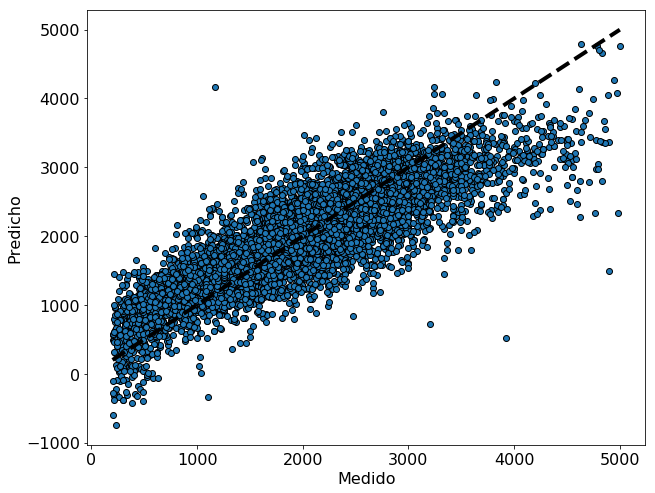

In [86]:
scatter(y_test, predictions2, y)

#### 7-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [87]:
# X_train, X_test, y_train, y_test

lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

# Ajustamos nuevamente, esta vez con regularizacion (LASSO)
lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))


r^2 Train: 0.7076135251163523
r^2 TEST: 0.6985502038923284


In [88]:
lasso_model.alpha

0.01

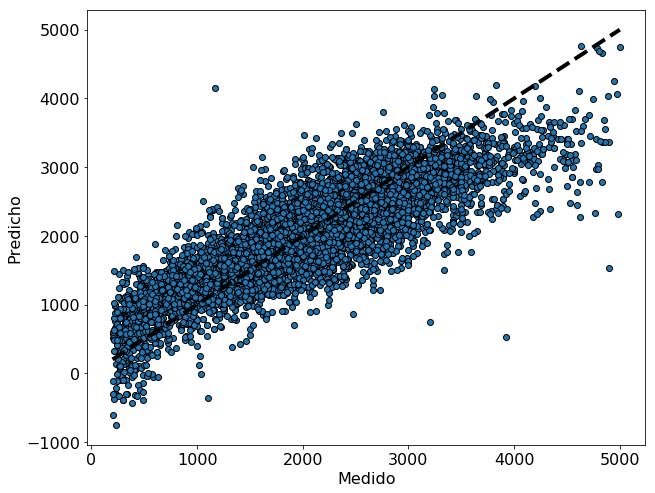

In [89]:
scatter(y_test, predictions2, y)

### 8) Vamos a crear una Feature que es el cuadrado de la feature "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamo "X3_cuad"

In [90]:
X3.shape

(35739, 1189)

In [91]:
X3.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '988/397', '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1189)

In [92]:
sup_x_sup = X3.surface_total_in_m2 * X3.surface_total_in_m2
sup_x_sup.name

'surface_total_in_m2'

In [93]:
sup_x_sup.rename("sup_x_sup", axis=1, inplace=True)
sup_x_sup.name

'sup_x_sup'

In [94]:
X3_cuad = pd.concat([X3, sup_x_sup],axis=1)
X3_cuad.shape

(35739, 1190)

In [95]:
X3_cuad.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419', 'sup_x_sup'], dtype='object', length=1190)

#### Probamos los diferentes modelos incluyendo nuestra nueva feature ("sup_x_sup"):
### "X3_cuad"

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad, y)

#### 8-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [97]:
rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))

r^2 Train: 0.7215873867382206
r^2 TEST: 0.7119482372147646


In [98]:
ridge_model.alpha

0.01

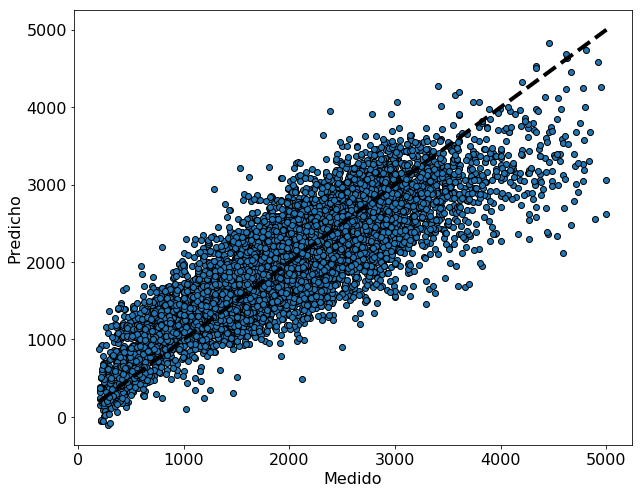

In [99]:
scatter(y_test, predictions2, y)

#### 8-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [100]:
lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))

r^2 Train: 0.7208133524794773
r^2 TEST: 0.7098242275100809


In [101]:
lasso_model.alpha

0.01

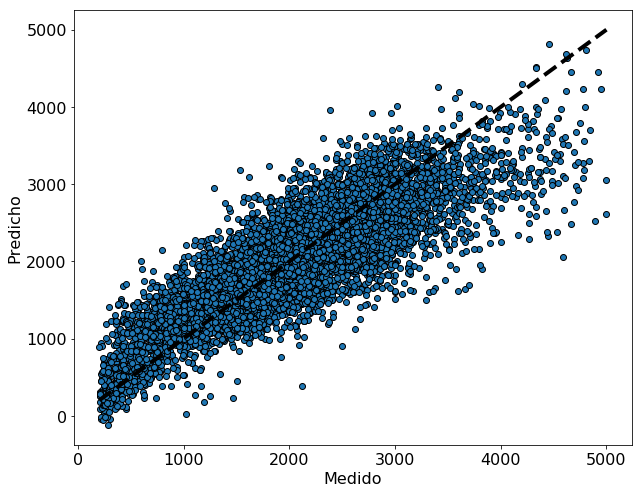

In [102]:
scatter(y_test, predictions2, y)

#### Para ambos modelos no hemos notado una variación significativa



#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### Importamos algunas librerías más requeridas para este punto

In [103]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

from sklearn.preprocessing import StandardScaler

# KFold: Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# OBJETO PARA CROSS-VALIDATION (K-Folds cross-validator) 
cv = KFold(3, shuffle=True)
# LO BUENO DE USAR ESTE OBJETO, ES QUE PODRÍA USARLO PARA HACER SIEMPRE LAS MISMAS PARTICIONES

#### 8-c) Ridge Regression CV (Cross Validation)

In [104]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))

{'alpha': 0.01, 'scores': array([0.70597354, 0.71193017, 0.70643287]), 'mean_score': 0.708112193358252}


In [105]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7119482372147627

#### 8-d) Lasso Regression CV (Cross Validation)

In [106]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.71073115, 0.70397533, 0.70878712]), 'mean_score': 0.707831196822892, 'zero_coefs': 892}


In [107]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7098242275100809

#### Se verificó para diferentes particiones los R2 Test y Train

### 9) Creación de Features Relacionales

#### Vamos a crear Features relacionando las columnas Dummie de las Parcelas con la columnas "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamos "X3_cuad_relac"

In [108]:
X3_cuad.shape

(35739, 1190)

In [109]:
X3_cuad.columns[0:20]

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', '1064/740', '1069/693', '1126/1645', '1127/1652', '1131/1652', '1131/1653', '1131/1654', '1132/1650'], dtype='object')

In [110]:
X3_cuad.columns[-1]

'sup_x_sup'

#### En base a las dos celdas anteriores SELECCIONAR A MANO LAS QUE NO VOY A MULTIPLICAR (las que no son dummies de posición y que hayan quedado luego de las sucesivas eliminaciones de fueatures con Pvalue > 0,01)

In [111]:
relac = X3_cuad.drop(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', 'sup_x_sup'],
                     axis=1)

In [112]:
relac.shape

(35739, 1177)

In [113]:
X3_cuad.surface_total_in_m2.shape

(35739,)

In [114]:
relaciones = relac.mul(X3_cuad.surface_total_in_m2, axis=0)
relaciones.shape

(35739, 1177)

In [115]:
relaciones[relaciones.columns[0]]

0         0.0
2         0.0
7         0.0
8         0.0
12        0.0
         ... 
118454    0.0
118464    0.0
118471    0.0
118482    0.0
118503    0.0
Name: 1064/740, Length: 35739, dtype: float64

In [116]:
relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0]

7007      35.0
36736     94.0
58190     57.0
61708     77.0
117155    55.0
Name: 1064/740, dtype: float64

In [117]:
# PEQUEÑA VERIFICACIÓN
display(X3_cuad.surface_total_in_m2[(relaciones[relaciones.columns[0]])>0])
print("")
display(relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0])  # miro cóm queda

7007      35.0
36736     94.0
58190     57.0
61708     77.0
117155    55.0
Name: surface_total_in_m2, dtype: float64

7007      35.0
36736     94.0
58190     57.0
61708     77.0
117155    55.0
Name: 1064/740, dtype: float64

In [118]:
columnas = list(range(relaciones.columns.size))
columnas[-1]

1176

In [119]:
relaciones.set_axis(columnas, axis=1, inplace=True)   # renombro las columnas nuevas (las relacionales)

In [120]:
relaciones.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176], dtype='int64', length=1177)

In [121]:
relaciones.shape

(35739, 1177)

In [122]:
X3_cuad_relac = pd.concat([X3_cuad, relaciones],axis=1)
X3_cuad_relac.shape

(35739, 2367)

In [123]:
X3_cuad_relac.columns

Index([  'surface_total_in_m2', 'surface_covered_in_m2',                'garage',              'lavadero',                'balcon',                 'patio',             'amenities',              'estrenar',              'gimnasio',               'baulera',
       ...
                          1167,                    1168,                    1169,                    1170,                    1171,                    1172,                    1173,                    1174,                    1175,                    1176], dtype='object', length=2367)

#### Probamos los diferentes modelos incluyendo nuestras nuevas features RELACIONALES:
### "X3_cuad_relac"

#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### con "X3_cuad_relac"

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac, y)

#### 9-a) Ridge Regression CV (Cross Validation)

In [125]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))


{'alpha': 0.01, 'scores': array([0.712477  , 0.69693173, 0.70597099]), 'mean_score': 0.705126574223342}


In [126]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7125218130201856

#### 9-b) Lasso Regression CV (Cross Validation)

In [127]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.71414508, 0.71452865, 0.70123942]), 'mean_score': 0.709971050081979, 'zero_coefs': 1926}


In [128]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7098774923928294

#### 9-c) Stats Model Linear

#### Armamos "X3_cuad_relac_const"

In [129]:
# USANDO statsmodel
# Tenemos que agregar explícitamente a una constante:
X3_cuad_relac_const = sm.add_constant(X3_cuad_relac)
X3_cuad_relac_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
X3_cuad_relac_const = X3_cuad_relac_const.astype("int", copy=True)   # lo paso a int sino no me da la memoria

In [131]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print("EMC train:", mean_squared_error(y_train, predictions))
print("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 187885.21398651623
EMC train: 204155.77795023294
R2:  0.7332471182735101
R2: train: 0.7332471182735101
R2: test: 0.7006851962723051


##### SE OBSERVA QUE BAJÓ EL R2 TEST

In [132]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     133.2
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:37:25   Log-Likelihood:            -2.0078e+05
No. Observations:               26804   AIC:                         4.026e+05
Df Residuals:                   26261   BIC:                         4.071e+05
Df Model:                         542                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1669.03

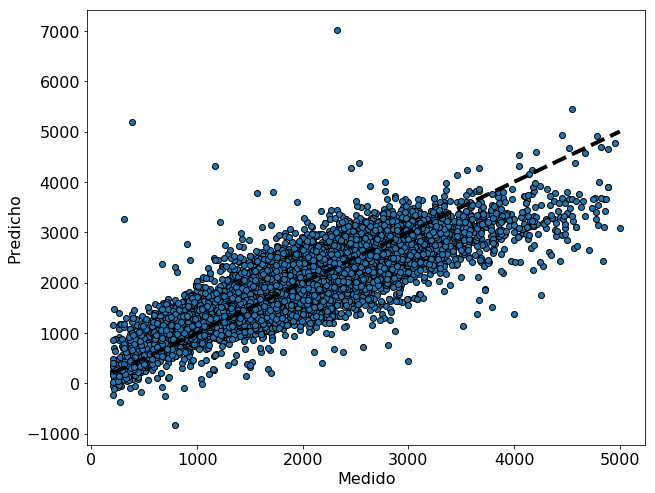

In [133]:
scatter(y_test, predictions2, y)

#### Tercer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [134]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['lavadero', '1064/740', '1126/1645', '1127/1652', '1132/1650',
       '1140/1631', '1167/1253', '1180/1702', '1189/1709', '1189/1711',
       '1191/1714', '1192/1715', '1195/1716', '1195/1718', '1219/1731',
       '1220/1731', '1221/1731', '1341/1574', '1341/1614', '1342/1578',
       '1347/1594', '1347/1596', '1348/1596', '1348/1597', '1349/1585',
       '1350/1596', '1352/1589', '1355/1575', '1355/1582', '1355/1585',
       '1356/1566', '1356/1584', '1358/1537', '1358/1558', '1358/1564',
       '1359/1546', '1359/1557', '1359/1558', '1359/1568', '1360/1542',
       '1362/1539', '1362/1557', '1363/1546', '1363/1547', '1363/1560',
       '1365/1565', '1366/1558', '1366/1564', '1366/1570', '1367/1543',
       '1370/1549', '1370/1552', '1370/1557', '1370/1560', '1370/1562',
       '1370/1563', '1371/1542', '1372/1534', '1372/1564', '1373/1557',
       '1374/1550', '1374/1556', '1374/1559', '1375/1554', '1375/1555',
       '1376/1547', '1376/1550', '1376/1553', '1377/1547', '1415/1

#### Armamos "X4_cuad_relac_const"

In [135]:
X4_cuad_relac_const = X3_cuad_relac_const.drop(not_feature_cols, axis=1)

In [136]:
X4_cuad_relac_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,balcon,patio,amenities,estrenar,gimnasio,baulera,...,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176
0,1,55,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,55,55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,45,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### STATS MODEL con "X4_cuad_relac_const"

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac_const, y)

In [138]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT

EMC train: 197039.16741741938
EMC train: 204633.34888839428
R2:  0.7173476540020324
R2: train: 0.7173476540020325
R2: test: 0.7092540667765224


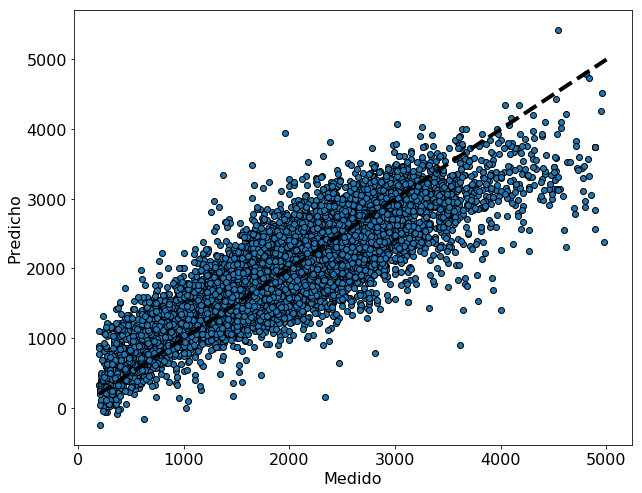

In [139]:
scatter(y_test, predictions2, y)

#### También probemos RIDGE_CV y LASSO_CV CON con "X4_cuad_relac"

#### armammos "X4_cuad_relac"

In [140]:
X4_cuad_relac = X4_cuad_relac_const.drop(["const"], axis=1)

In [141]:
X4_cuad_relac.head(3)

,surface_total_in_m2,surface_covered_in_m2,garage,balcon,patio,amenities,estrenar,gimnasio,baulera,piscina_house,...,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176
0,55,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,45,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### probamos con "X4_cuad_relac"

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac, y)

#### 9-d) Lasso Regression CV (Cross Validation)

In [143]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.70304895, 0.70064132, 0.69977612]), 'mean_score': 0.7011554649194709, 'zero_coefs': 1524}


In [144]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7087711946308621

#### 9-e) Ridge Regression CV (Cross Validation)

##### Ridge CV (Cross Validation)

In [145]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.68834695, 0.69302212, 0.69666721]), 'mean_score': 0.6926787613439291}


In [146]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7101965316002606

<hr id="ToCSV">
<h2 style="color: lightblue">CONCLUSIONES</h2>